In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

In [2]:
def load_sudoku(filename: str) -> list[list[int]]:
    with open(f"sudoku_boards/{filename}", "r") as file:
        return [[int(x) for x in (row[:-1] if row[-1]=='\n' else row)] for row in file.readlines()]

In [3]:
def show_sudoku(board: list[list[int]], filled: bool = True, filename: str =""):
    m = 360
    d = m // 9
    img = Image.new(mode="RGB", size=(m, m), color=(176, 165, 155))
    draw = ImageDraw.Draw(img)
    for i in range(9):
        draw.line([(i*d, 0), (i*d, m)], width=1, fill=(0, 0, 0))
        draw.line([(0, i*d), (m, i*d)], width=1, fill=(0, 0, 0))

    for i in range(1, 3):
        draw.line([(3*i*d, 0), (3*i*d, m)], width=3, fill=(0, 0, 0))
        draw.line([(0, 3*i*d), (m, 3*i*d)], width=3, fill=(0, 0, 0))

    font = ImageFont.truetype("arial.ttf", 20)
    for i in range(9):
        for j in range(9):
            fill_color = 'blue' if fixed[i][j] else 'red'
            if fixed[i][j] or filled:
                draw.text((j*d + d/2.5, i*d + d/3.5), text=str(board[i][j]), font=font, fill=fill_color)
    display(img)
    if filename:
        img.save(f"solved_sudoku_boards/{filename}.png")

def plot_energy(energy: list[int]):
    plt.plot([ind for ind in range(len(energy))], energy)
    plt.title("Energy plot")
    plt.show()


def plot_temperature(temperature: list[float]):
    plt.plot([ind for ind in range(len(temperature))], temperature)
    plt.title("Temperature plot")
    plt.show()

#### Neighbor generating function

In Sudoku, numbers cannot repeat in any column, row, or 3x3 square. It's most challenging to continuously check the condition for squares, but it's known that each square must contain a permutation of digits from 1 to 9. Therefore, initially, I fill in the numbers so that they do not repeat within one square. Generating neighbors involves randomly selecting any square out of 9, and then swapping two random numbers within it.

The Square class describes the empty spaces inside each square



In [4]:

class Square:
    def __init__(self, x: int, y: int, board: list[list[int]]) -> None:
        self.x = x
        self.y = y
        self.positions = []
        self.fill_positions(board)
        self.length = len(self.positions)

    def fill_positions(self, board: list[list[int]]) -> None:
        number = [False for _ in range(9)]
        empty_spots = []
        for i in range(self.x, self.x + 3):
            for j in range(self.y, self.y + 3):
                if fixed[i][j]:
                    number[board[i][j] - 1] = True
                else:
                    empty_spots.append((i, j))

        for i in range(9):
            if not number[i]:
                pos = empty_spots.pop()
                self.positions.append(pos)
                board[pos[0]][pos[1]] = i + 1

def initial_fill(board: list[list[int]]) -> list[Square]:
    sqr = [i for i in range(9)]
    square_id = 0
    t = [0, 3, 6]
    for x in t:
        for y in t:
            sqr[square_id] = Square(x, y, board)
            square_id += 1
    return sqr


The cost function calculates number of repetitions of numbers for every row and column and then adds them all up. We don't have to worry about the repetitions within the 3x3 squares, because they are already taken care of by the way generating initial state and finding neighbors work. The goal is to find the state with energy equal to zero. It's the value for solved sudoku board.

In [5]:
def count_cols_and_rows(board, rows_count, columns_count):
    for i in range(9):
        for j in range(9):
            rows_count[i][board[i][j] - 1] += 1
            columns_count[j][board[i][j] - 1] += 1

def calculate_initial_energy(rows_count, columns_count):
    energy = 0
    for i in range(9):
        for j in range(9):
            energy += rows_count[i][j] - 1 if rows_count[i][j] > 0 else 0
            energy += columns_count[i][j] - 1 if columns_count[i][j] > 0 else 0
    return energy

def calculate_cur_energy(r1, r2, c1, c2, num1, num2, rows_count, columns_count):
    energy = 0
    for row in [r1, r2]:
        for num in [num1, num2]:
            energy += rows_count[row][num - 1] - 1 if rows_count[row][num - 1] > 0 else 0

    for col in [c1, c2]:
        for num in [num1, num2]:
            energy += columns_count[col][num - 1] - 1 if columns_count[col][num - 1] > 0 else 0
    return energy

In [9]:
def swap_nums(
        board: list[list[int]], 
        pos1: tuple[int, int], 
        pos2: tuple[int, int], 
        rows_count: list[list[int]], 
        columns_count: list[list[int]]
) -> None:
    num1 = board[pos1[0]][pos1[1]]
    num2 = board[pos2[0]][pos2[1]]

    board[pos1[0]][pos1[1]], board[pos2[0]][pos2[1]] = board[pos2[0]][pos2[1]], board[pos1[0]][pos1[1]]

    rows_count[pos1[0]][num1 - 1] -= 1
    columns_count[pos1[1]][num1 - 1] -= 1
    rows_count[pos2[0]][num2 - 1] -= 1
    columns_count[pos2[1]][num2 - 1] -= 1

    rows_count[pos2[0]][num1 - 1] += 1
    columns_count[pos2[1]][num1 - 1] += 1
    rows_count[pos1[0]][num2 - 1] += 1
    columns_count[pos1[1]][num2 - 1] += 1


def neighbor(
        board: list[list[int]], 
        squares: list[Square], 
        rows_count: list[list[int]], 
        columns_count: list[list[int]]
) -> tuple[tuple[int, int], int]:
    square_id = np.random.randint(0, 9)
    square = squares[square_id]
    m = square.length
    a = np.random.randint(0, m - 1)
    b = np.random.randint(a + 1, m)
    pos1 = square.positions[a]
    pos2 = square.positions[b]

    num1 = board[pos1[0]][pos1[1]]
    num2 = board[pos2[0]][pos2[1]]

    before = calculate_cur_energy(pos1[0], pos2[0], pos1[1], pos2[1], num1, num2, rows_count, columns_count)
    swap_nums(board, pos1, pos2, rows_count, columns_count)
    after = calculate_cur_energy(pos1[0], pos2[0], pos1[1], pos2[1], num2, num1, rows_count, columns_count)
    return (pos1, pos2), after - before

In [10]:
def check_correctness(board: list[list[int]]) -> bool:
    row_check = [[False for _ in range(9)] for _ in range(9)]
    col_check = [[False for _ in range(9)] for _ in range(9)]
    square_check = [[False for _ in range(9)] for _ in range(9)]
    for i in range(9):
        for j in range(9):
            if row_check[i][board[i][j] - 1]:
                return False
            row_check[i][board[i][j] - 1] = True
            if col_check[j][board[i][j] - 1]:
                return False
            col_check[j][board[i][j] - 1] = True

            square_id = (i // 3)*3 + (j // 3)
            if square_check[square_id][board[i][j] - 1]:
                return False
            square_check[square_id][board[i][j] - 1] = True

    return True

### Simulated annealing algorithm

Similar to tasks one and two, I use the same probability function, where 
$\Delta E$ is the change in energy, and $T$ is the temperature in a given iteration. For a given temperature level, I perform more than one iteration of searching for successive states. Additionally, unlike the previous programs, there is an additional outer loop. It is responsible for "reheating." In Sudoku, only a solution with an energy level of 0 is sought, and a state with a low energy level can be very far from the optimal solution. Therefore, when the algorithm reaches such a low but nonzero energy state, it is very difficult to reach an optimal solution at low temperature. In such a situation, the search is restarted, but at a lower initial temperature. The initial temperature of successive such processes is inversely proportional to the iteration number, and within one process, the temperature decreases exponentially.

In [11]:
def f(delta, T):
    return np.exp(-delta/T)

In [12]:
def annealing(board, T0 = 100, alpha = 0.99, steps=1000, no_of_iter=10, max_iter = 10, filename=""):
    show_sudoku(board, filled=False, filename=f"unsolved_{filename}")
    squares = initial_fill(board)
    columns_count = [[0 for _ in range(9)] for _ in range(9)]
    rows_count = [[0 for _ in range(9)] for _ in range(9)]
    count_cols_and_rows(board, rows_count, columns_count)

    cur_energy = calculate_initial_energy(rows_count, columns_count)
    energy_states = [cur_energy]


    T = T0
    temperature = [T]
    stop = False
    iter_so_far = 1
    while not stop and iter_so_far < max_iter:
        for i in range(steps):
            for _ in range(no_of_iter):
                change, delta = neighbor(board, squares, rows_count, columns_count)
                if delta < 0:
                    cur_energy += delta
                else:
                    probability = f(delta, T)
                    if probability > np.random.uniform(0, 1):
                        cur_energy += delta
                    else:
                        swap_nums(board, change[0], change[1], rows_count, columns_count)
                energy_states.append(cur_energy)
                if cur_energy == 0:
                    stop = True
                    break
            T *= alpha
            temperature.append(T)
            if stop:
                break
        iter_so_far += 1
        T = T0 / iter_so_far


    show_sudoku(board, filename=f"solved_{filename}")

    print(f"Number of reheating {iter_so_far - 1}")
    plot_energy(energy_states)
    plot_temperature(temperature)

### Results for different Sudoku puzzles

I obtained various boards from the website https://sudoku.com/. Text files with these boards are located in the sudoku_boards folder. The difficulty levels are easy, medium, hard, expert, and diabolical, corresponding to the respective difficulty levels on the mentioned website. I also included the "empty" board - empty and the "nondeterministic" board, which is partially filled but does not have a unique solution.

Function to  calculate time of solving. ( Includes the time spent on drawing sudoku board and plots)

In [15]:
from time import perf_counter

def time(func, *args, **kwargs):
    t = perf_counter()
    func(*args, **kwargs)
    print(f"Measured time: {np.round(perf_counter() - t, 2)}")

In [16]:
sudoku = load_sudoku("sudoku_easy")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

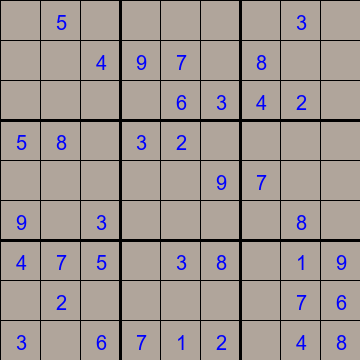

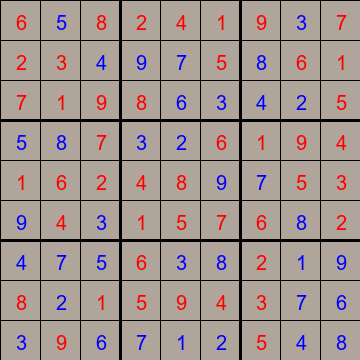

Number of reheating 2


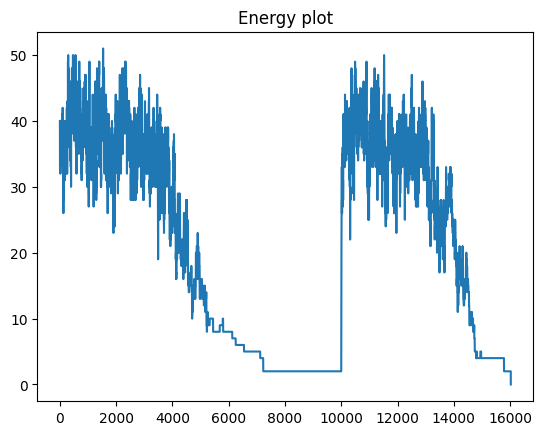

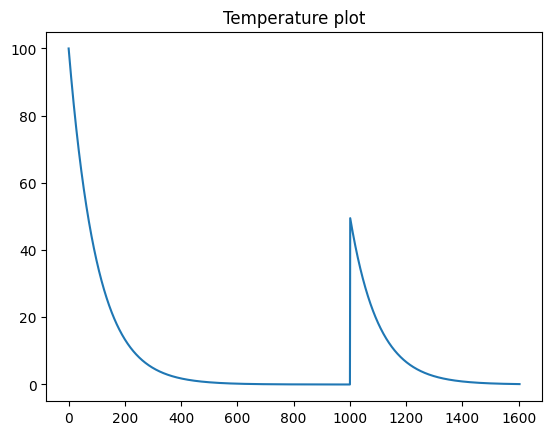

Measured time: 0.75
Is correct: True


In [17]:
time(annealing, sudoku, max_iter=1000, filename="easy")
print(f"Is correct: {check_correctness(sudoku)}")

In [18]:
sudoku = load_sudoku("sudoku_medium")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

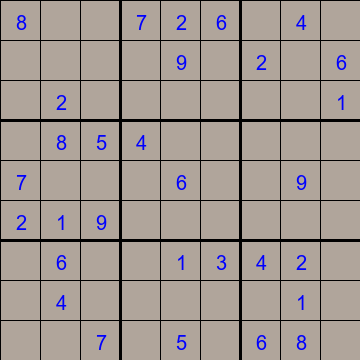

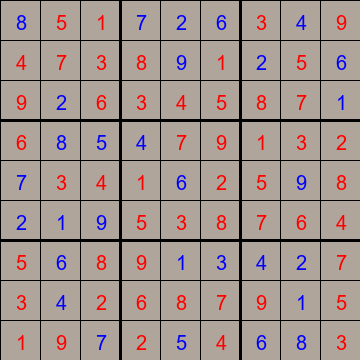

Number of reheating 1


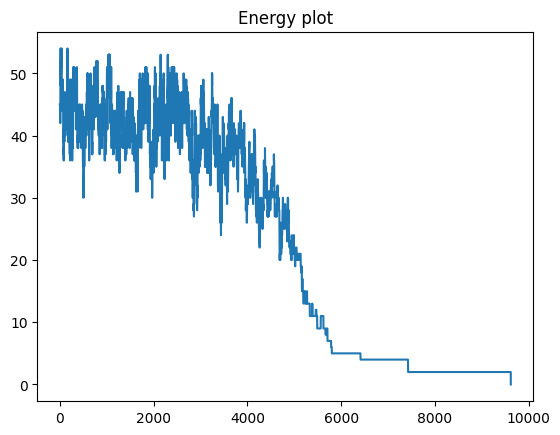

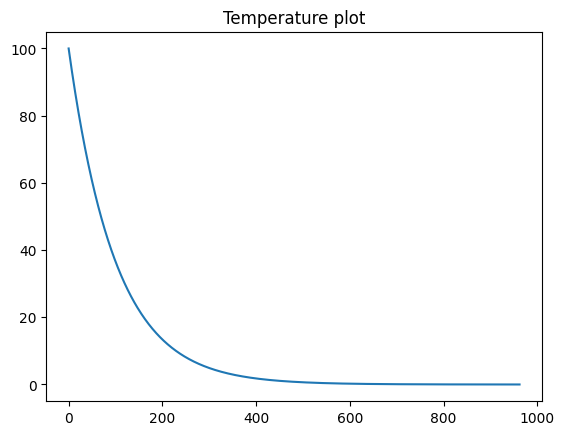

Measured time: 0.53
Is correct: True


In [19]:
time(annealing, sudoku, max_iter=1000, filename="medium")
print(f"Is correct: {check_correctness(sudoku)}")

For Sudoku puzzles at the easy and medium levels, there were no problems. They were solved almost immediately every time.

In [20]:
sudoku = load_sudoku("sudoku_hard")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

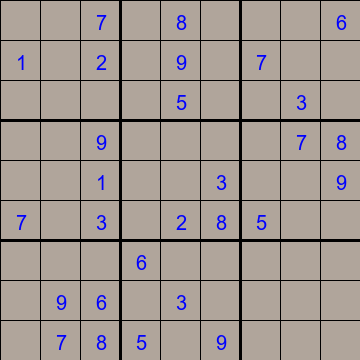

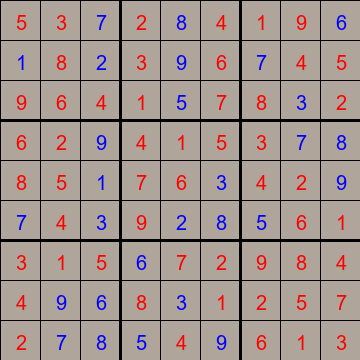

Number of reheating 60


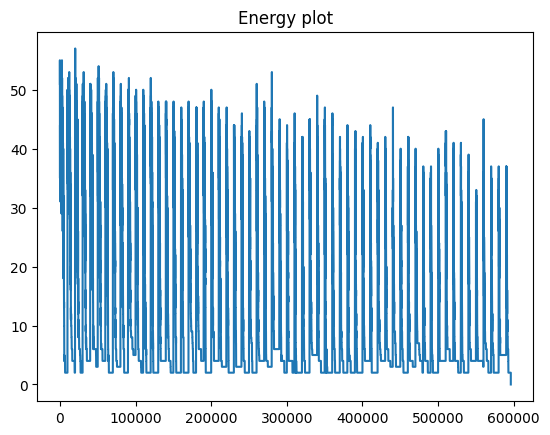

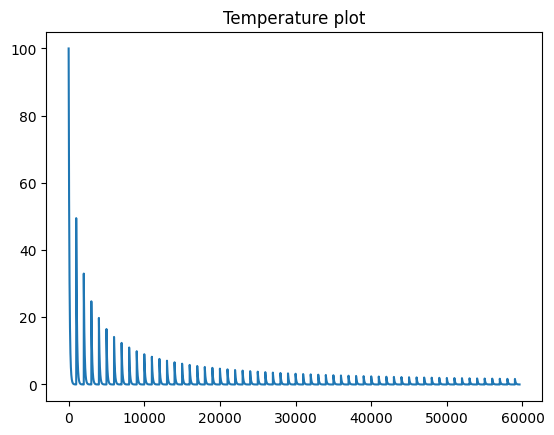

Measured time: 12.54
Is correct: True


In [21]:
time(annealing, sudoku, max_iter=1000, filename="hard")
print(f"Is correct: {check_correctness(sudoku)}")

It took much more time to solve hard sudoku.

In [24]:
sudoku = load_sudoku("sudoku_expert")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

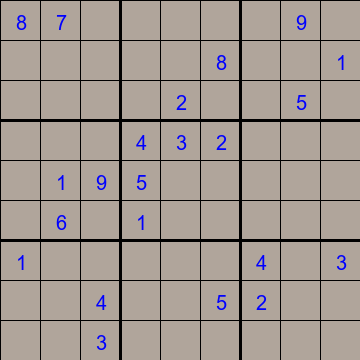

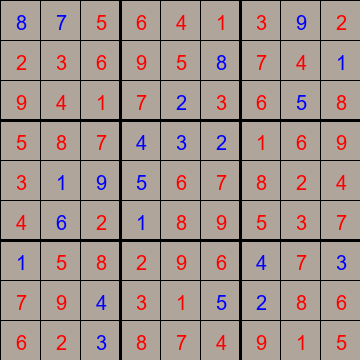

Number of reheating 141


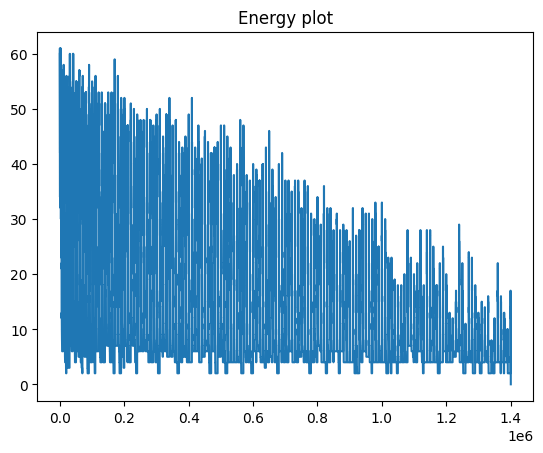

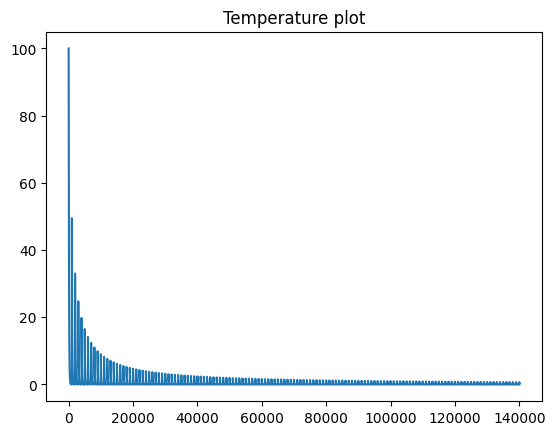

Measured time: 30.98
Is correct: True


In [25]:
time(annealing, sudoku, max_iter=1000, filename="expert")
print(f"Is correct: {check_correctness(sudoku)}")

The result for the sudoku_extreme puzzle was much more random. Sometimes, just over twenty reheating iterations were sufficient, or as many as 130.

In [26]:
sudoku = load_sudoku("sudoku_evil")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

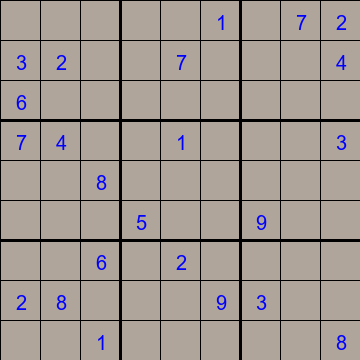

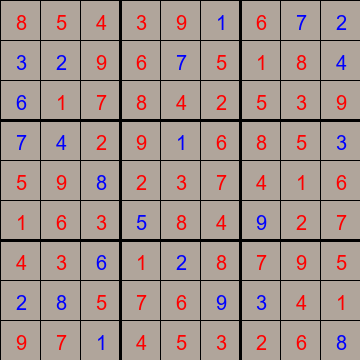

Number of reheating 84


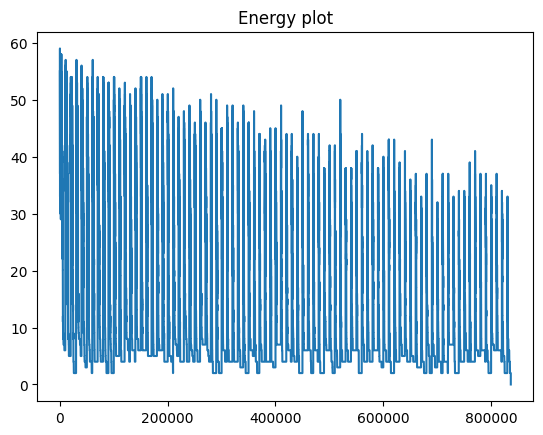

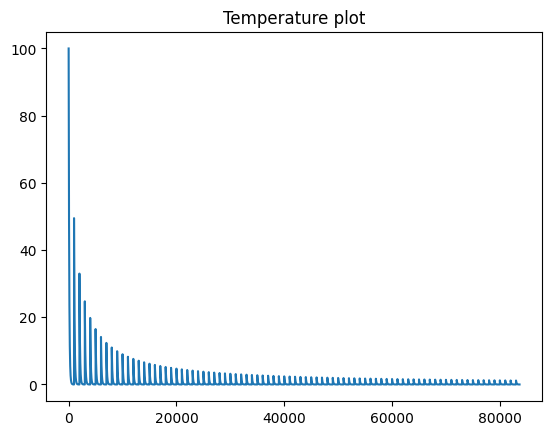

Measured time: 21.41
Is correct: True


In [27]:
time(annealing, sudoku, max_iter=1000, filename="evil")
print(f"Is correct: {check_correctness(sudoku)}")

Evil sudoku turned out to be the hardest

In the end, there were the "empty" and "nondeterministic" puzzles, but both were solved very quickly

In [28]:
sudoku = load_sudoku("sudoku_empty")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

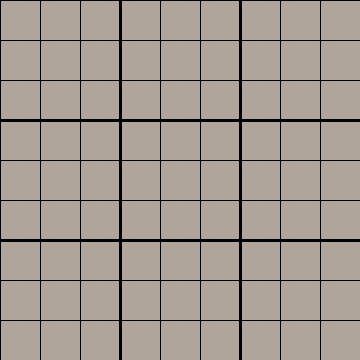

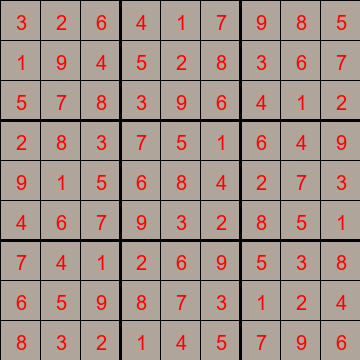

Number of reheating 1


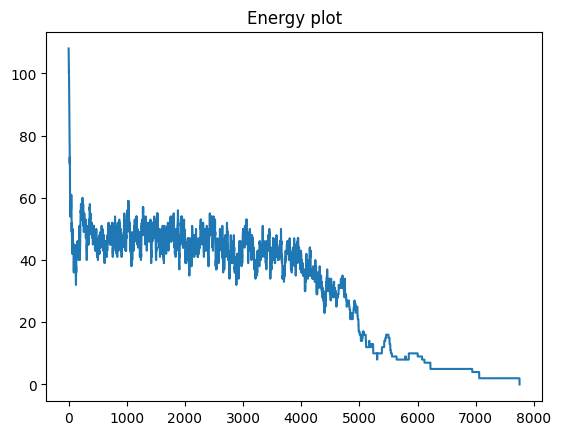

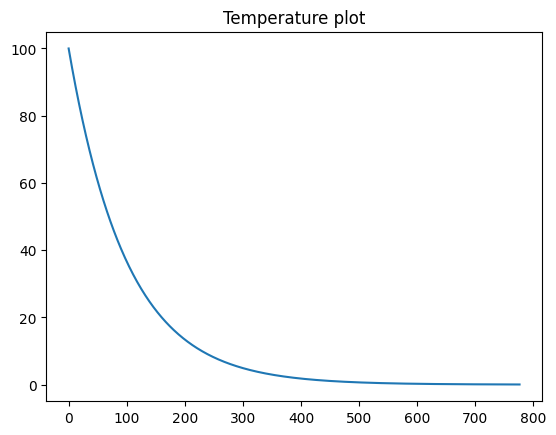

Measured time: 0.51
Is correct: True


In [29]:
time(annealing, sudoku, max_iter=100, filename="empty")
print(f"Is correct: {check_correctness(sudoku)}")

In [30]:
sudoku = load_sudoku("sudoku_nondeterministic")
fixed = [[1 if sudoku[i][j] else 0 for j in range(9)] for i in range(9)]

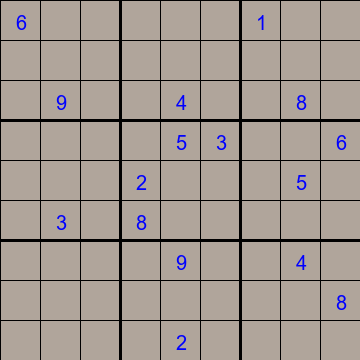

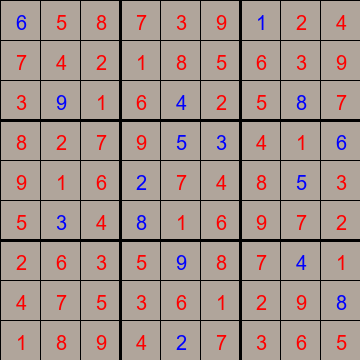

Number of reheating 1


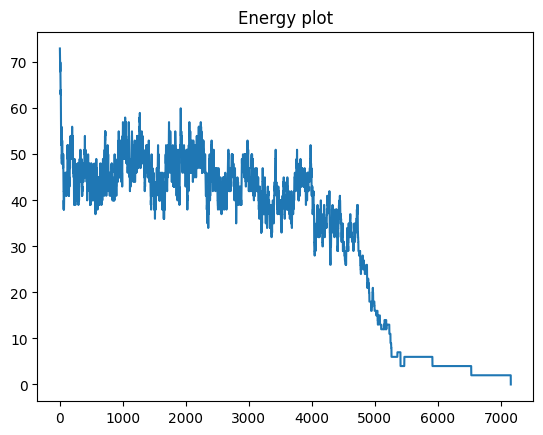

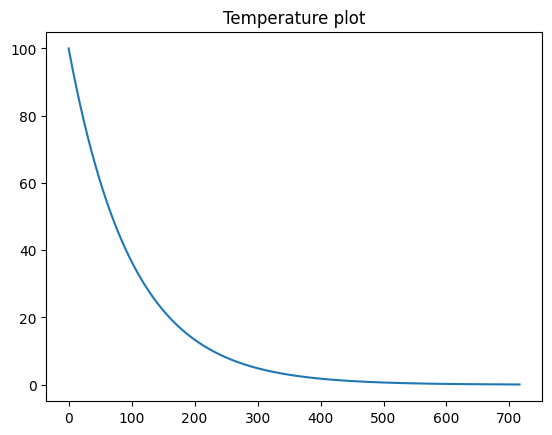

Measured time: 0.6
Is correct: True


In [31]:
time(annealing, sudoku, max_iter=100, filename="nondeterministic")
print(f"Is correct: {check_correctness(sudoku)}")